# Talk Page Contributor Analysis

[Task](https://phabricator.wikimedia.org/T233261)

## Purpose

We are curious to know the number of distinct junior contributors contributing to talk pages and how that number has changed over time.

This information will be helpful to 
(1) establish a baseline for one of the key results for the project: Increasing the number of junior contributors participating in conversations on talk pages by 5%
(2) inform target wiki selection


This report includes:
* A table that compares the number of distinct "junior contributors" who have contributed to a talk page in the past 30 days and the number of distinct "junior contributors" who contributed to talk pages in a similar 30-day window, 18 months ago.
* Time series chart showing the year-over-year variation in the monthly distinct number of "junior contributors" who have contributed to a talk page from August 2014 - August 2019
* A breakdown of number of distinct contributors by experience level and by wikipedia to help inform selection of target wiki





## Current Definitions

- Junior contributor: Registerd users who have made <100 cumulative edits to Wikipedia.
- Senior contributor: Registered users who have made >500 cumulative edits to Wikipedia. 
- Participating on Talk Pages: Successfully contributed to any of the 16 Wikipedia talk page namespaces that results in a diff that is not reverted. Only looking at Wikipedia Projects

See current list: https://phabricator.wikimedia.org/T234046

In [149]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue); library(tidyverse); library(glue); library(lubridate)
    library(scales)
})

## Collect Data

In [90]:
# Talk page editors who have edited Wikipedia by wiki and experience level
query <- 
"SELECT
  date,
  wiki,
  user_name,
  count(*) as talk_edits, 
  user_is_bot,
  user_edit_count_bucket
FROM
  ( 
  SELECT
    trunc(event_timestamp, 'MONTH') as date,
    wiki_db as wiki,
    event_user_text as user_name,
    page_namespace_historical,
    ARRAY_CONTAINS(event_user_groups_historical, 'bot') as user_is_bot,
    CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count < 100 THEN 'under 100'
            WHEN event_user_revision_count >=100 AND event_user_revision_count < 500 THEN '100-499'
            ELSE '500+'
            END AS user_edit_count_bucket
FROM wmf.mediawiki_history mwh
inner join canonical_data.wikis 
on
    wiki_db = database_code and
    database_group ==  'wikipedia'
WHERE
    event_timestamp >= '2014-09-01' and 
    event_timestamp < '2019-10-01' and 
    event_entity = 'revision' and
    event_type = 'create' and
    snapshot = '2019-09' and 
    page_namespace_historical % 2 == 1   -- all talk pages have odd numbered page_namespace 
) as info
GROUP BY
    date,
    wiki,
    user_name,
    user_is_bot,
    user_edit_count_bucket"

In [91]:
talk_edits <- wmf::query_hive(query)

In [92]:
talk_edits$date <- as.Date(talk_edits$date, format = "%Y-%m-%d")

## Overall # of Monthly Unique Junior Contributors 

In [96]:
junior_contributors_monthly <- talk_edits %>%
  filter(user_is_bot == 'false',
        user_edit_count_bucket == 'under 100') %>%
  group_by(date) %>%
  summarise(junior_contributors = n_distinct(user_name),
            talk_edits_total = sum(talk_edits))

In [150]:
tail(junior_contributors_monthly)

date,junior_contributors,talk_edits_total
<date>,<int>,<int>
2019-04-01,25043,69557
2019-05-01,22866,63241
2019-06-01,20001,56080
2019-07-01,20985,60089
2019-08-01,22302,61926
2019-09-01,25438,70288


In [98]:
average_contributors_monthly <- junior_contributors_monthly %>%
   filter(date >= '2018-09-01')  %>% #look at last 12 months
   summarise(average_monthly_contributors = mean(junior_contributors))

average_contributors_monthly

average_monthly_contributors
<dbl>
24319.38


There are an average of 2.4K unique junior contributors per month that contribute to talk pages on wikipedias.

In [99]:
junior_contributors_monthly_yoy <- junior_contributors_monthly %>%
   arrange(date) %>%
   mutate(yoy_percent = (junior_contributors/lag(junior_contributors,12) -1) *100) %>%
   arrange(desc(date))

head(junior_contributors_monthly_yoy, 10)

date,junior_contributors,talk_edits_total,yoy_percent
<date>,<int>,<int>,<dbl>
2019-09-01,25438,70288,3.6762308
2019-08-01,22302,61926,-1.7056724
2019-07-01,20985,60089,-0.4081439
2019-06-01,20001,56080,-5.4505058
2019-05-01,22866,63241,-0.9357941
2019-04-01,25043,69557,-5.8073495
2019-03-01,26528,74329,-5.7318503
2019-02-01,25917,73736,0.6055666
2019-01-01,27369,73693,-2.1067315


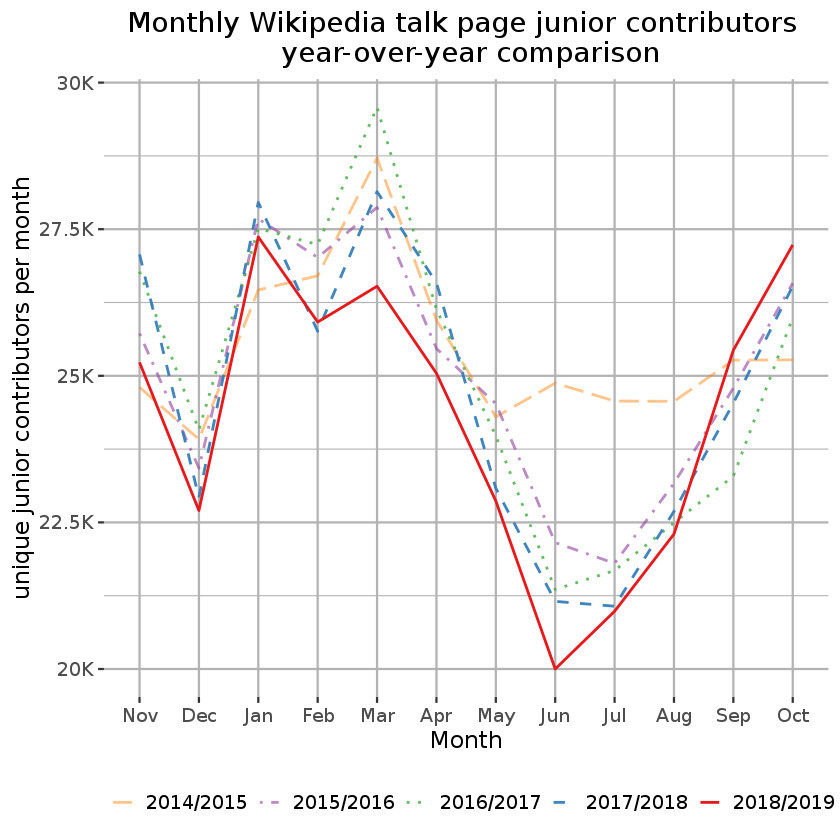

In [146]:
# Plot YoY Changes for Junior Contributors

junior_contributor_yoy_plot <- junior_contributors_monthly_yoy %>%
 filter (date != '2014-09-01') %>% #Remove extra month to do equal comparison between year
 mutate(year = case_when(date >= '2014-10-01' & date < '2015-10-01' ~ '2014/2015',
                         date >= '2015-10-01' & date < '2016-10-01' ~ '2015/2016',
                         date >= '2016-10-01' & date < '2017-10-01' ~ '2016/2017',
                         date >= '2017-10-01' & date < '2018-10-01' ~ '2017/2018',
                         date >= '2018-10-01' & date < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(date),"%m")),
         Month = months(as.Date(date), abbreviate=TRUE))


junior_contributor_yoy_plot$MonthN = factor(junior_contributor_yoy_plot$MonthN, levels=c( "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09", "10"))

junior_contributor_yoy_plot$year = factor(junior_contributor_yoy_plot$year, levels = c('2014/2015','2015/2016','2016/2017','2017/2018','2018/2019'))


p <- ggplot(junior_contributor_yoy_plot, aes(x=MonthN, y = junior_contributors, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 0.8) +
  scale_y_continuous("unique junior contributors per month", labels = polloi::compress) +
  scale_x_discrete(breaks = junior_contributor_yoy_plot$MonthN, labels = junior_contributor_yoy_plot$Month )+
  labs(title = "Monthly Wikipedia talk page junior contributors \n year-over-year comparison") +
        xlab("Month") +
        scale_color_brewer(palette = 'Set1', breaks=c('2014/2015','2015/2016', '2016/2017','2017/2018', '2018/2019'), direction=-1) +
        scale_linetype_manual(breaks=c('2014/2015','2015/2016', '2016/2017','2017/2018', '2018/2019'), values=c(5,4,3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm")) 


ggsave(filename="junior_contributor_yoy_plot.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p

This data follows similar seasonal trends we see with overall pageview data. The number of junior contributors contributing to talk pages decreases around the holidays/Christmas and from May to June.

There's primarily been a decline in the number of junior contributors with some year over year increase occuring during the year. Notably there was a year over year increase from September to October 2019, with the number of monthly distinct contributors surpassing all the past previous year.

## Overall number of unique junior contributors participating on talk pages by experience level

In [102]:
contributors_monthly_byeditcount <- talk_edits %>%
  filter(user_is_bot == 'false',
        user_edit_count_bucket != 'undefined') %>%
  group_by(date, user_edit_count_bucket) %>%
  summarise(contributors = n_distinct(user_name),
            talk_edits_total = sum(talk_edits))

head(contributors_monthly_byeditcount)

date,user_edit_count_bucket,contributors,talk_edits_total
<date>,<chr>,<int>,<int>
2014-09-01,100-499,6340,38422
2014-09-01,500+,20297,900345
2014-09-01,under 100,23596,71256
2014-10-01,100-499,6420,40499
2014-10-01,500+,20545,918895
2014-10-01,under 100,25273,73165


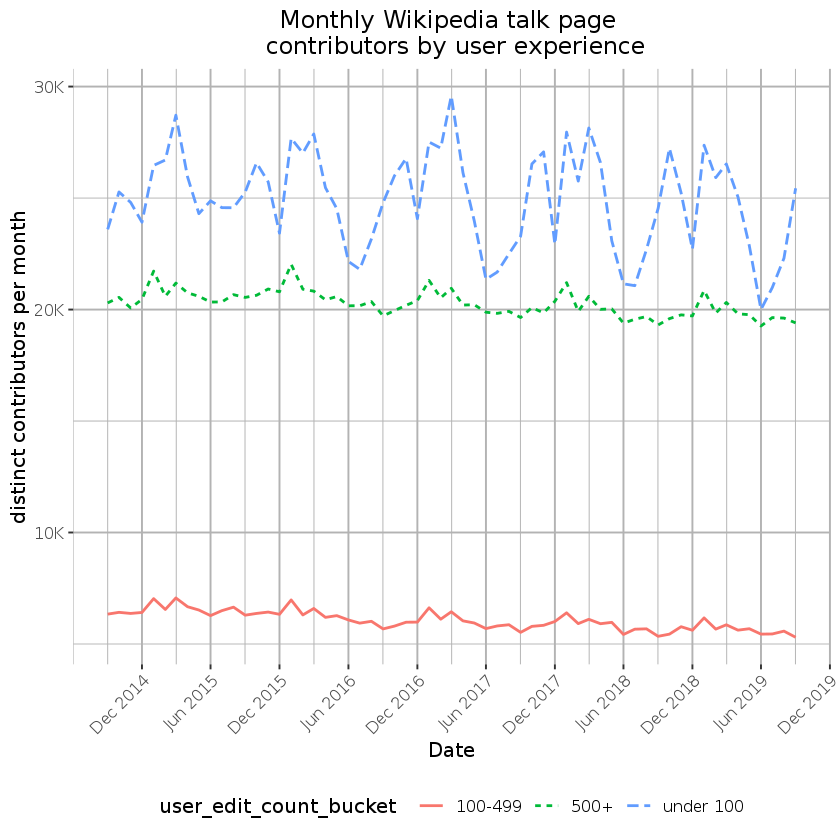

In [142]:
#Plot timeseries of unique contributors by experience level

p <- ggplot(contributors_monthly_byeditcount, aes(x= date, y = contributors, color = user_edit_count_bucket, linetype = user_edit_count_bucket)) +    
  geom_line(size =0.8) +
  scale_y_continuous("distinct contributors per month", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "6 months") +
  labs(title = "Monthly Wikipedia talk page \n contributors by user experience") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')


ggsave(filename="contributors_byuserexperience.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p

There are greater fluctuations with junior contributors with under 100 edits; however, there are also more unique contributors in this experience level group than the 500+ or the under 100 edits experience level groups.

In [104]:
head(contributors_monthly_byeditcount)

date,user_edit_count_bucket,contributors,talk_edits_total
<date>,<chr>,<int>,<int>
2014-09-01,100-499,6340,38422
2014-09-01,500+,20297,900345
2014-09-01,under 100,23596,71256
2014-10-01,100-499,6420,40499
2014-10-01,500+,20545,918895
2014-10-01,under 100,25273,73165


In [105]:
#Calculate YOY changes for each user edit count bucket

contributors_monthly_under100_yoy <- talk_edits %>%
    filter(user_is_bot == 'false',
    user_edit_count_bucket == 'under 100') %>%
    group_by(date) %>%
    summarise(contributors = n_distinct(user_name)) %>%
    arrange(date) %>%
    mutate(yoy_percent = (contributors/lag(contributors,12) -1) *100) %>%
    arrange(desc(date))


contributors_monthly_100_yoy <- talk_edits %>%
    filter(user_is_bot == 'false',
    user_edit_count_bucket == '100-499') %>%
    group_by(date) %>%
    summarise(contributors = n_distinct(user_name)) %>%
    arrange(date) %>%
    mutate(yoy_percent = (contributors/lag(contributors,12) -1) *100) %>%
    arrange(desc(date))


contributors_monthly_500_yoy <- talk_edits %>%
    filter(user_is_bot == 'false',
    user_edit_count_bucket == '500+') %>%
    group_by(date) %>%
    summarise(contributors = n_distinct(user_name)) %>%
    arrange(date) %>%
    mutate(yoy_percent = (contributors/lag(contributors,12) -1) *100) %>%
    arrange(desc(date))

In [106]:
# yoy table for September 2019
edit_count <- c('under 100', '100+', '500+')
contributors_monthy_byeditcount_yoy <- rbind(contributors_monthly_under100_yoy [1,], contributors_monthly_100_yoy [1,], contributors_monthly_500_yoy [1,])

contributors_monthy_byeditcount_yoy$edit_count= edit_count

contributors_monthy_byeditcount_yoy 

date,contributors,yoy_percent,edit_count
<date>,<int>,<dbl>,<chr>
2019-09-01,25438,3.6762308,under 100
2019-09-01,5302,-0.8044902,100+
2019-09-01,19401,0.4816656,500+


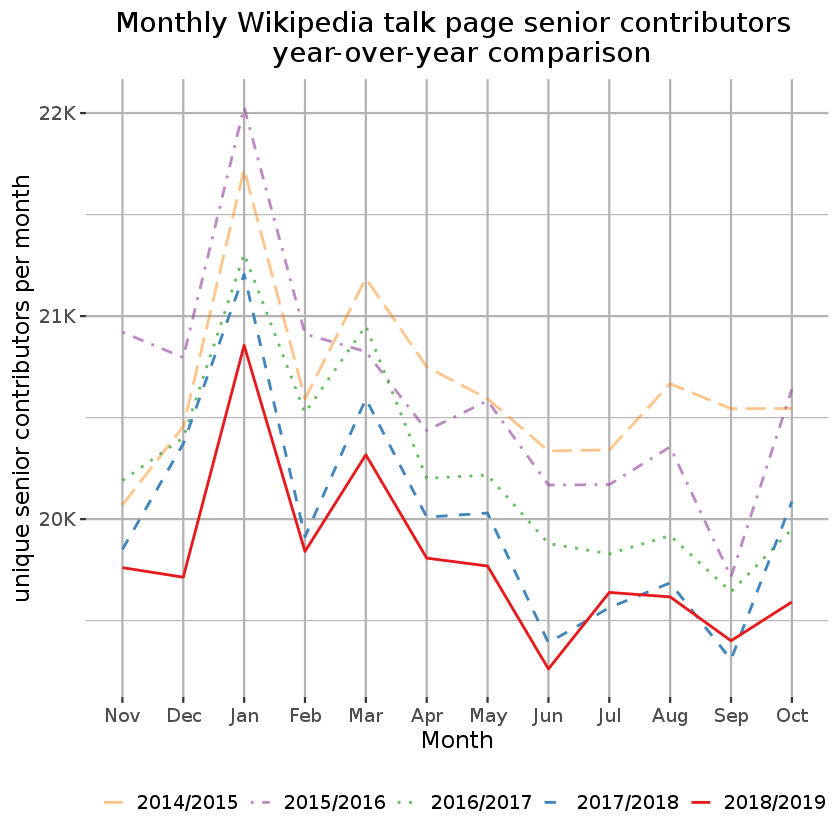

In [148]:
# Create YoY plot for senior contributors

# Plot YoY Changes for Junior Contributors

senior_contributor_yoy_plot <- contributors_monthly_500_yoy %>%
 filter(date != '2014-09-01') %>% #Remove extra month to do equal comparison between year
 mutate(year = case_when(date >= '2014-10-01' & date < '2015-10-01' ~ '2014/2015',
                         date >= '2015-10-01' & date < '2016-10-01' ~ '2015/2016',
                         date >= '2016-10-01' & date < '2017-10-01' ~ '2016/2017',
                         date >= '2017-10-01' & date < '2018-10-01' ~ '2017/2018',
                         date >= '2018-10-01' & date < '2019-10-01' ~ '2018/2019'),
         MonthN =as.factor(format(as.Date(date),"%m")),
         Month = months(as.Date(date), abbreviate=TRUE))


senior_contributor_yoy_plot$MonthN = factor(senior_contributor_yoy_plot$MonthN, levels=c( "11", "12", "01", "02", "03", 
                                                                           "04", "05", "06", "07", "08", "09", "10"))

senior_contributor_yoy_plot$year = factor(senior_contributor_yoy_plot$year, levels = c('2014/2015','2015/2016','2016/2017','2017/2018','2018/2019'))


p <- ggplot(senior_contributor_yoy_plot, aes(x=MonthN, y = contributors, group = year, color = year, linetype = year, alpha = year)) +    
  geom_line(size = 0.8) +
  scale_y_continuous("unique senior contributors per month", labels = polloi::compress) +
  scale_x_discrete(breaks = junior_contributor_yoy_plot$MonthN, labels = junior_contributor_yoy_plot$Month )+
  labs(title = "Monthly Wikipedia talk page senior contributors \n year-over-year comparison") +
        xlab("Month") +
        scale_color_brewer(palette = 'Set1', breaks=c('2014/2015','2015/2016', '2016/2017','2017/2018', '2018/2019'), direction=-1) +
        scale_linetype_manual(breaks=c('2014/2015','2015/2016', '2016/2017','2017/2018', '2018/2019'), values=c(5,4,3,2,1)) +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(0.5,"cm")) 


ggsave(filename="senior_contributor_yoy_plot.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p

There's primiarly been a year over year decline in the number of monthly distinct senior contributors participating on talk pages; however, there were some recent year over year increase in July and September 2019.

## Number of Unique Contributors By Wiki 

Review the number of unique contributors by wiki that participate on talk pages over the past 12 months.

In [121]:

contributors_monthly_bywiki <- talk_edits %>%
    filter(user_is_bot == 'false',
           date >= '2018-09-01',  #look at last 12 months
       ) %>% 
    group_by(date, wiki) %>%
    summarise(contributors = n_distinct(user_name),
            talk_edits_total = sum(talk_edits))
    

head(contributors_monthly_bywiki)

date,wiki,contributors,talk_edits_total
<date>,<chr>,<int>,<int>
2018-09-01,abwiki,2,7
2018-09-01,acewiki,6,43
2018-09-01,afwiki,40,1048
2018-09-01,akwiki,1,1
2018-09-01,alswiki,13,85
2018-09-01,amwiki,6,11


In [122]:
# Top 10 by average number of contributors participating on talk pages per month

contributors_average_bywiki <- contributors_monthly_bywiki %>%
    group_by(wiki)  %>%
    summarise(avg_contributors = mean(contributors)) %>%
    arrange(desc(avg_contributors))

head(contributors_average_bywiki, 10)

wiki,avg_contributors
<chr>,<dbl>
enwiki,33032.077
dewiki,7774.692
frwiki,3822.615
eswiki,3263.077
ruwiki,2908.769
itwiki,2046.385
jawiki,1733.000
fawiki,1312.846
hewiki,1269.846


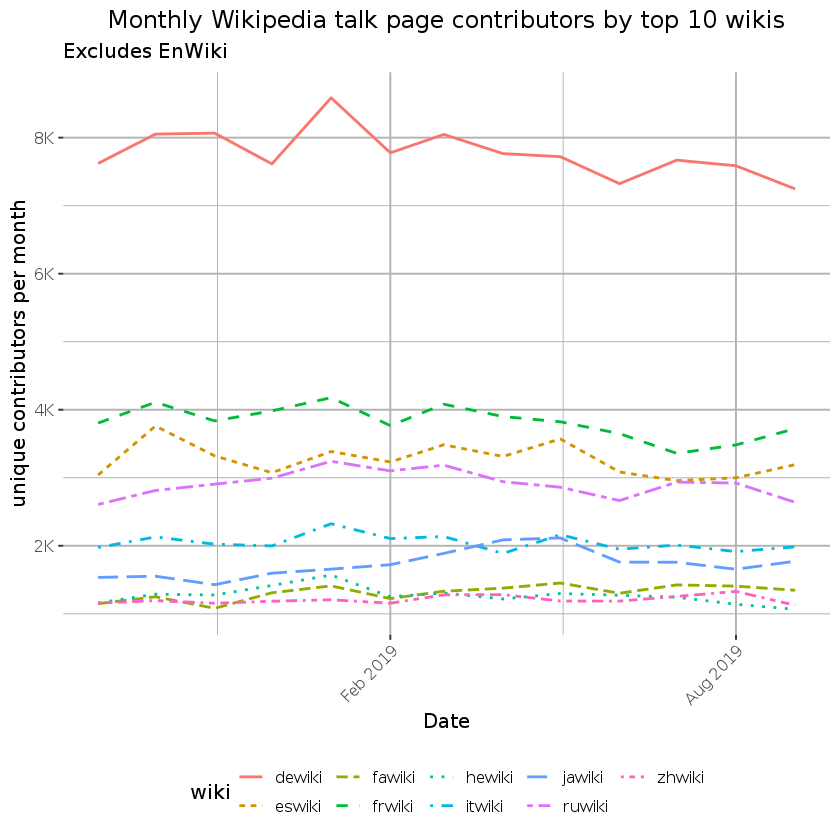

In [124]:
# Plot time series of the top 10 wikis overall

p <- contributors_monthly_bywiki %>%
    filter(wiki %in% c('dewiki', 'frwiki', 'eswiki', 'ruwiki', 'itwiki', 'jawiki', 'fawiki', 'hewiki', 'zhwiki')) %>%
    ggplot( aes(x= date, y = contributors, color = wiki, linetype = wiki)) +    
        geom_line(size =0.8) +
        scale_y_continuous("unique contributors per month", labels = polloi::compress) +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "6 months") +
        labs(title = "Monthly Wikipedia talk page contributors by top 10 wikis",
            subtitle = "Excludes EnWiki") +
        ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
        scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
        ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
        theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')


ggsave(filename="contributors_monthly_bywiki.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p


### Breakdown by Experience Level

In [116]:
contributors_monthly_bywiki_byeditcount <- talk_edits %>%
    filter(user_is_bot == 'false',
           date >= '2018-09-01', #look at last 12 months
           user_edit_count_bucket != 'undefined' 
       ) %>% 
    group_by(date, wiki, user_edit_count_bucket) %>%
    summarise(contributors = n_distinct(user_name),
            talk_edits_total = sum(talk_edits))
    

head(contributors_monthly_bywiki_byeditcount)

date,wiki,user_edit_count_bucket,contributors,talk_edits_total
<date>,<chr>,<chr>,<int>,<int>
2018-09-01,abwiki,500+,1,4
2018-09-01,abwiki,under 100,1,3
2018-09-01,acewiki,500+,2,13
2018-09-01,acewiki,under 100,2,26
2018-09-01,afwiki,100-499,6,12
2018-09-01,afwiki,500+,15,1000


In [131]:
# Junior Contributors: Top 10 by average number of contributors per month by experience

contributors_average_bywiki_junior <- contributors_monthly_bywiki_byeditcount %>%
    filter(user_edit_count_bucket == 'under 100') %>%
    group_by(wiki)  %>%
    summarise(avg_junior_contributors = mean(contributors)) %>%
    arrange(desc(avg_junior_contributors))

head(contributors_average_bywiki_junior, 10)

wiki,avg_junior_contributors
<chr>,<dbl>
enwiki,13427.4615
dewiki,1365.1538
frwiki,1337.4615
eswiki,1092.0000
fawiki,819.7692
ruwiki,750.1538
arwiki,611.7692
itwiki,548.0000
ptwiki,449.2308


In [132]:
head(contributors_monthly_bywiki_byeditcount)

date,wiki,user_edit_count_bucket,contributors,talk_edits_total
<date>,<chr>,<chr>,<int>,<int>
2018-09-01,abwiki,500+,1,4
2018-09-01,abwiki,under 100,1,3
2018-09-01,acewiki,500+,2,13
2018-09-01,acewiki,under 100,2,26
2018-09-01,afwiki,100-499,6,12
2018-09-01,afwiki,500+,15,1000


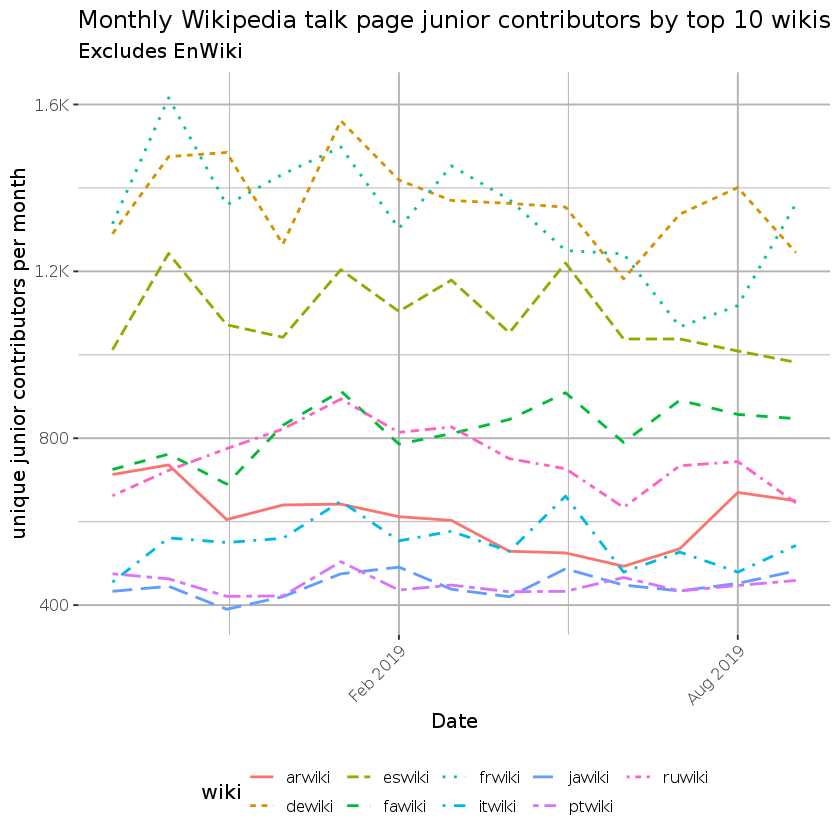

In [136]:
# Plot time series of the top 10 wikis - junior contributors

p <- contributors_monthly_bywiki_byeditcount  %>%
    filter(user_edit_count_bucket == 'under 100',
           wiki %in% c('dewiki', 'frwiki', 'eswiki', 'fawiki', 'ruwiki', 'arwiki', 'itwiki', 'ptwiki', 'jawiki')) %>%
    ggplot( aes(x= date, y = contributors, color = wiki, linetype = wiki)) +    
        geom_line(size =0.8) +
        scale_y_continuous("unique junior contributors per month", labels = polloi::compress) +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "6 months") +
        labs(title = "Monthly Wikipedia talk page junior contributors by top 10 wikis",
            subtitle = "Excludes EnWiki") +
        ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
        scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
        ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
        theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')


ggsave(filename="junior_contributors_monthly_bywiki.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p


In [134]:
# Senior Contributors: Top 10 by average number of contributors per month by experience

contributors_average_bywiki_senior <- contributors_monthly_bywiki_byeditcount %>%
    filter(user_edit_count_bucket == '500+') %>%
    group_by(wiki)  %>%
    summarise(avg_junior_contributors = mean(contributors)) %>%
    arrange(desc(avg_junior_contributors))

head(contributors_average_bywiki_senior , 10)

wiki,avg_junior_contributors
<chr>,<dbl>
enwiki,8020.6154
dewiki,2636.9231
frwiki,1452.5385
ruwiki,1018.0000
eswiki,739.6923
itwiki,690.6923
jawiki,573.0769
zhwiki,538.2308
plwiki,445.0769


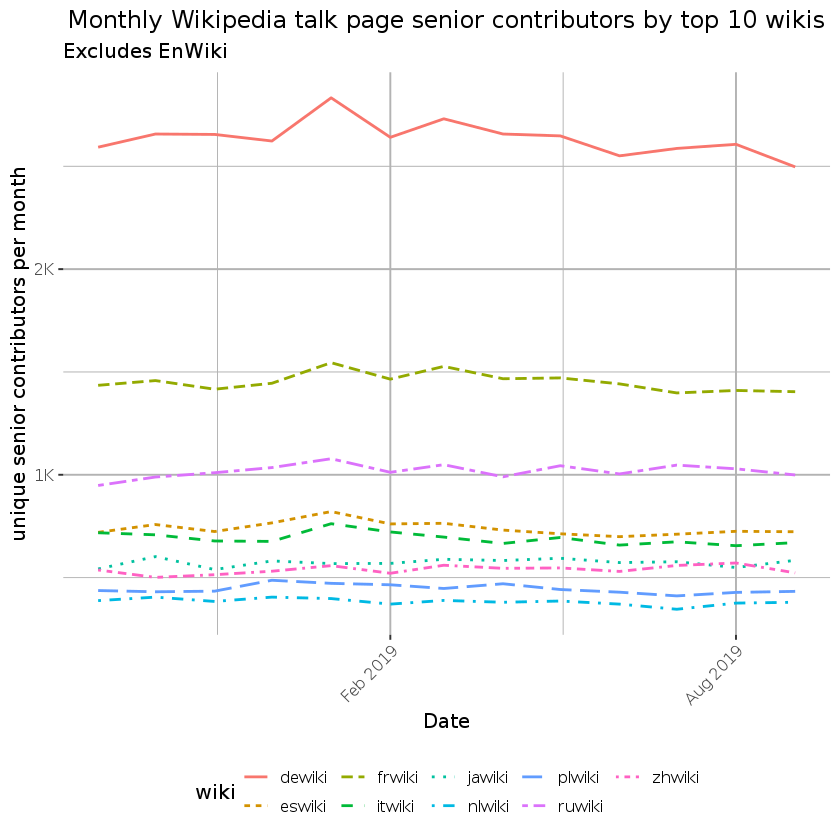

In [135]:
# Plot time series of the top 10 wikis - senior contributors

p <- contributors_monthly_bywiki_byeditcount  %>%
    filter(user_edit_count_bucket == '500+',
           wiki %in% c('dewiki', 'frwiki','ruwiki', 'eswiki', 'itwiki', 'jawiki', 'zhwiki', 'plwiki', 'nlwiki')) %>%
    ggplot( aes(x= date, y = contributors, color = wiki, linetype = wiki)) +    
        geom_line(size =0.8) +
        scale_y_continuous("unique senior contributors per month", labels = polloi::compress) +
        scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "6 months") +
        labs(title = "Monthly Wikipedia talk page senior contributors by top 10 wikis",
            subtitle = "Excludes EnWiki") +
        ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
        scale_alpha_manual(values = c(0.45, 0.65, 0.85, 0.95, 1)) +
        ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
        theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom')


ggsave(filename="senior_contributors_monthly_bywiki.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p

In [ ]:
# Plot stacked bar chart showing propotion of user edit count

In [137]:
head(contributors_monthly_bywiki_byeditcount)

date,wiki,user_edit_count_bucket,contributors,talk_edits_total
<date>,<chr>,<chr>,<int>,<int>
2018-09-01,abwiki,500+,1,4
2018-09-01,abwiki,under 100,1,3
2018-09-01,acewiki,500+,2,13
2018-09-01,acewiki,under 100,2,26
2018-09-01,afwiki,100-499,6,12
2018-09-01,afwiki,500+,15,1000


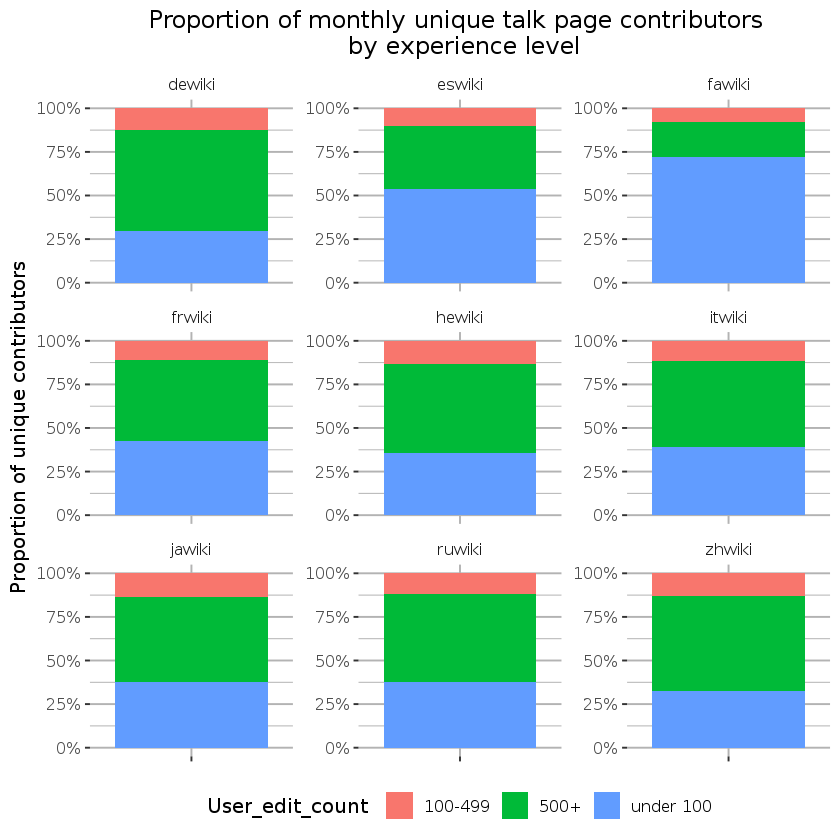

In [152]:
p <- contributors_monthly_bywiki_byeditcount %>%
    filter(wiki %in% c('dewiki', 'frwiki', 'eswiki', 'ruwiki', 'itwiki', 'jawiki', 'fawiki', 'hewiki', 'zhwiki')) %>%
    group_by(wiki, user_edit_count_bucket) %>% 
    summarise(avg_contributors = mean(contributors))%>% 
    ungroup()%>%
    ggplot(aes(x=factor(1), y= avg_contributors, fill = user_edit_count_bucket)) + 
    geom_col(position="fill") +
    scale_y_continuous(labels = scales::percent_format()) +
    facet_wrap(~ wiki, scale = "free_y") +
    labs(title = "Proportion of monthly unique talk page contributors \n by experience level",
        fill = "User_edit_count",
        x = NULL,
        y = "Proportion of unique contributors") +
  ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_blank(),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position="bottom")

ggsave(filename="contributors_monthly_bywiki_stackedbar.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p